In [1]:
import os
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Set your working directory [Do not forget to make a short-cut of the folder shared by Galina to your Drive]
os.chdir('/content/drive/MyDrive/#WaterSoftHack25 - Water quality project/Project Codes/input datafiles/')

# 1. Data Loading & Preparation


In [4]:
# Import instantaneous data file
#df = pd.read_csv('11447650_cleaned_daily_data_plus_precip_turb_short.csv')
df = pd.read_csv('11447650_filled_daily_data.csv', parse_dates=['DATE'])
# Convert to datetime and set as index
df = df.set_index('DATE')

In [6]:
print("dat_daily - Percentage of missing values per column:")
nan_percent_daily = (df.isna().sum() / len(df)) * 100
print(nan_percent_daily.round(2).map("{}%".format))

dat_daily - Percentage of missing values per column:
SSC_mg_L         0.0%
SSD_st_d         0.0%
Discharge_cfs    0.0%
Precip_in        0.0%
Turb_fnu         0.0%
dtype: object


# 2. Enhanced Feature Engineering

In [7]:
# Temporal features
df['doy'] = df.index.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['doy']/365)
df['doy_cos'] = np.cos(2 * np.pi * df['doy']/365)

# Hydrological features
df['Discharge_Change'] = df['Discharge_cfs'].diff()
df['Discharge_Change_3d'] = df['Discharge_cfs'].diff(3)

# Enhanced precipitation features
df['Antecedent_Precip_1d'] = df['Precip_in'].shift(1)
df['Antecedent_Precip_3d'] = df['Precip_in'].rolling(3).sum().shift(1)
df['Antecedent_Precip_7d'] = df['Precip_in'].rolling(7).sum().shift(1)
df['Antecedent_Precip_14d'] = df['Precip_in'].rolling(14).sum().shift(1)

# Enhanced discharge features
df['Cumul_Discharge_3d'] = df['Discharge_cfs'].rolling(3).sum()
df['Cumul_Discharge_7d'] = df['Discharge_cfs'].rolling(7).sum()
df['Cumul_Discharge_14d'] = df['Discharge_cfs'].rolling(14).sum()

# Event flags
df['Monsoon_Season'] = ((df.index.month >= 6) & (df.index.month <= 9)).astype(int)
df['High_Flow'] = (df['Discharge_cfs'] > df['Discharge_cfs'].quantile(0.85)).astype(int)
df['Recent_Storm'] = (df['Antecedent_Precip_7d'] > df['Antecedent_Precip_7d'].quantile(0.9)).astype(int)

# Remove initial NaNs
df = df.dropna()

In [8]:
df.columns

Index(['SSC_mg_L', 'SSD_st_d', 'Discharge_cfs', 'Precip_in', 'Turb_fnu', 'doy',
       'doy_sin', 'doy_cos', 'Discharge_Change', 'Discharge_Change_3d',
       'Antecedent_Precip_1d', 'Antecedent_Precip_3d', 'Antecedent_Precip_7d',
       'Antecedent_Precip_14d', 'Cumul_Discharge_3d', 'Cumul_Discharge_7d',
       'Cumul_Discharge_14d', 'Monsoon_Season', 'High_Flow', 'Recent_Storm'],
      dtype='object')

In [9]:
# 3. Feature Selection & Scaling

features = [
    'Turb_fnu',
    'Discharge_cfs',
    'Discharge_Change',
    'Discharge_Change_3d',
    'Antecedent_Precip_1d',
    'Antecedent_Precip_3d',
    'Antecedent_Precip_7d',
    'Antecedent_Precip_14d',
    'Cumul_Discharge_3d',
    'Cumul_Discharge_7d',
    'Cumul_Discharge_14d',
    'doy_sin',
    'doy_cos',
    'High_Flow',
    'Recent_Storm',
    'Monsoon_Season'
]

# Separate scalers for features and target
x_scaler = RobustScaler()
y_scaler = RobustScaler()

X_scaled = x_scaler.fit_transform(df[features])
y_scaled = y_scaler.fit_transform(df[['SSC_mg_L']])

scaled_df = pd.DataFrame(X_scaled, columns=features, index=df.index)
scaled_df['SSC_mg_L'] = y_scaled

In [10]:
# 4. Sequence Creation

# Use fixed 60-day lookback for all sequences
LOOK_BACK = 60  # Fixed sequence length

def create_sequences(data, features, look_back=LOOK_BACK):
    """Creates sequences with fixed lookback length"""
    X, y, indices = [], [], []

    for i in range(look_back, len(data)):
        start_idx = i - look_back
        X.append(data[features].iloc[start_idx:i].values)
        y.append(data['SSC_mg_L'].iloc[i])
        indices.append(data.index[i])

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y, indices

X, y, seq_dates = create_sequences(scaled_df, features, look_back=LOOK_BACK)

print(f"Final sequence shape: {X.shape}")


Final sequence shape: (4975, 60, 16)


In [11]:
# 5. Temporal Train-Validation-Test Split

# Create date-based masks using your date range
dates = pd.DatetimeIndex(seq_dates)

# Define split points (using hydrological years)
train_end = '2018-09-30'  # End of training period
val_end = '2021-09-30'    # End of validation period

train_mask = (dates <= train_end)
val_mask = (dates > train_end) & (dates <= val_end)
test_mask = (dates > val_end)

# Split data
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train: {X_train.shape} ({dates[train_mask].min().date()} to {dates[train_mask].max().date()})")
print(f"Val: {X_val.shape} ({dates[val_mask].min().date()} to {dates[val_mask].max().date()})")
print(f"Test: {X_test.shape} ({dates[test_mask].min().date()} to {dates[test_mask].max().date()})")


Train: (3150, 60, 16) (2010-02-15 to 2018-09-30)
Val: (1096, 60, 16) (2018-10-01 to 2021-09-30)
Test: (729, 60, 16) (2021-10-01 to 2023-09-29)


In [12]:
# 6. Enhanced GRU Model Architecture

def build_gru_model(input_shape):
    model = Sequential([
        Masking(mask_value=-999, input_shape=input_shape),
        GRU(128, activation='tanh', return_sequences=True),
        Dropout(0.4),
        GRU(64, activation='tanh', return_sequences=True),
        Dropout(0.3),
        GRU(32, activation='tanh'),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.keras.losses.Huber(),
        metrics=['mae']
    )
    return model

# Determine input shape
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_gru_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 128)        │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,321 (407.50 KB)

 Trainable params: 104,321 (407.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 7. Training with Enhanced Callbacks

callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint(
        'best_monsoon_model.h5', save_best_only=True, monitor='val_loss'
    )
]


In [14]:
# 8. Model Training

# Calculate steps per epoch
batch_size = 32
steps_per_epoch = max(1, len(X_train) // batch_size)
validation_steps = max(1, len(X_val) // batch_size)

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.5212 - mae: 0.8131

98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - loss: 0.5205 - mae: 0.8123 - val_loss: 0.1008 - val_mae: 0.3117 - learning_rate: 5.0000e-04
Epoch 2/300
 1/98 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.2356 - mae: 0.4961

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2356 - mae: 0.4961 - val_loss: 0.0980 - val_mae: 0.3069 - learning_rate: 5.0000e-04
Epoch 3/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3859 - mae: 0.6512

98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - loss: 0.3859 - mae: 0.6512 - val_loss: 0.0852 - val_mae: 0.2760 - learning_rate: 5.0000e-04
Epoch 4/300
 1/98 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - loss: 0.2003 - mae: 0.4921

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2003 - mae: 0.4921 - val_loss: 0.0840 - val_mae: 0.2737 - learning_rate: 5.0000e-04
Epoch 5/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 0.3556 - mae: 0.6220 - val_loss: 0.0953 - val_mae: 0.2959 - learning_rate: 5.0000e-04
Epoch 6/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1337 - mae: 0.3711 - val_loss: 0.0867 - val_mae: 0.2834 - learning_rate: 5.0000e-04
Epoch 7/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 169ms/step - loss: 0.3361 - mae: 0.5922 - val_loss: 0.1038 - val_mae: 0.3337 - learning_rate: 5.0000e-04
Epoch 8/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1350 - mae: 0.4225 - val_loss: 0.1073 - val_mae: 0.3402 - learning_rate: 5.0000e-04
Epoch 9/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 0.3143 - mae: 0.5799 - val_loss: 0.1315 - val_mae: 0.3661 - learning_rate: 5.0000e-04
Epoch 10/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2199 - mae: 0.5074 - val_loss: 0.1218 - val_mae: 0.3521 - learning_

98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - loss: 0.2776 - mae: 0.5256 - val_loss: 0.0834 - val_mae: 0.2899 - learning_rate: 2.5000e-04
Epoch 18/300
 1/98 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.0891 - mae: 0.3505

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0891 - mae: 0.3505 - val_loss: 0.0828 - val_mae: 0.2903 - learning_rate: 2.5000e-04
Epoch 19/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - loss: 0.2073 - mae: 0.4468 - val_loss: 0.0862 - val_mae: 0.2914 - learning_rate: 2.5000e-04
Epoch 20/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2983 - mae: 0.5469 - val_loss: 0.0848 - val_mae: 0.2915 - learning_rate: 2.5000e-04
Epoch 21/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - loss: 0.2387 - mae: 0.4794 - val_loss: 0.1059 - val_mae: 0.3286 - learning_rate: 2.5000e-04
Epoch 22/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1102 - mae: 0.3495 - val_loss: 0.1093 - val_mae: 0.3332 - learning_rate: 2.5000e-04
Epoch 23/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 416ms/step - loss: 0.2322 - mae: 0.4785 - val_loss: 0.1022 - val_mae: 0.3207 - learning_rate: 2.5000e-04
Epoch 24/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3572 - mae: 0.6930 - val_loss: 0.1095 - val_mae: 0.3318 - lear

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1887 - mae: 0.3774 - val_loss: 0.0825 - val_mae: 0.2867 - learning_rate: 1.2500e-04
Epoch 35/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 0.1795 - mae: 0.4117 - val_loss: 0.0965 - val_mae: 0.3182 - learning_rate: 1.2500e-04
Epoch 36/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.9566 - mae: 2.2284 - val_loss: 0.0986 - val_mae: 0.3216 - learning_rate: 1.2500e-04
Epoch 37/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - loss: 0.1814 - mae: 0.4133 - val_loss: 0.1050 - val_mae: 0.3315 - learning_rate: 1.2500e-04
Epoch 38/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1830 - mae: 0.4335 - val_loss: 0.1023 - val_mae: 0.3279 - learning_rate: 1.2500e-04
Epoch 39/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - loss: 0.1760 - mae: 0.4030 - val_loss: 0.0924 - val_mae: 0.2989 - learning_rate: 1.2500e-04
Epoch 40/300
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0513 - mae: 0.2566 - val_loss: 0.0930 - val_mae: 0.2988 - lear

In [15]:
# 9. Model Evaluation & Visualization

# Load best model
model = tf.keras.models.load_model('best_monsoon_model.h5')

# Predictions
y_train_pred = model.predict(X_train) if len(X_train) > 0 else np.array([])
y_test_pred = model.predict(X_test) if len(X_test) > 0 else np.array([])
y_val_pred = model.predict(X_val) if len(X_val) > 0 else np.array([])

# Inverse scaling function
def inverse_scale_y(y, scaler):
    """Safely inverse transform target values"""
    if len(y) == 0:
        return np.array([])
    return scaler.inverse_transform(y.reshape(-1, 1)).flatten()

# Inverse scaling
y_train_actual = inverse_scale_y(y_train, y_scaler)
y_val_actual = inverse_scale_y(y_val, y_scaler)
y_test_actual = inverse_scale_y(y_test, y_scaler)
y_train_pred_actual = inverse_scale_y(y_train_pred, y_scaler)
y_val_pred_actual = inverse_scale_y(y_val_pred, y_scaler)
y_test_pred_actual = inverse_scale_y(y_test_pred, y_scaler)

# Performance Metrics
def nash_sutcliffe(obs, sim):
    """Calculate Nash-Sutcliffe Efficiency"""
    if len(obs) == 0 or len(sim) == 0 or len(obs) != len(sim):
        return float('nan')
    return 1 - np.sum((obs - sim)**2) / np.sum((obs - np.mean(obs))**2)

train_nse = nash_sutcliffe(y_train_actual, y_train_pred_actual)
val_nse = nash_sutcliffe(y_val_actual, y_val_pred_actual)
test_nse = nash_sutcliffe(y_test_actual, y_test_pred_actual)

print(f"Train NSE: {train_nse:.3f}")
print(f"Validation NSE: {val_nse:.3f}")
print(f"Test NSE: {test_nse:.3f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
Train NSE: 0.759
Validation NSE: 0.802
Test NSE: 0.701


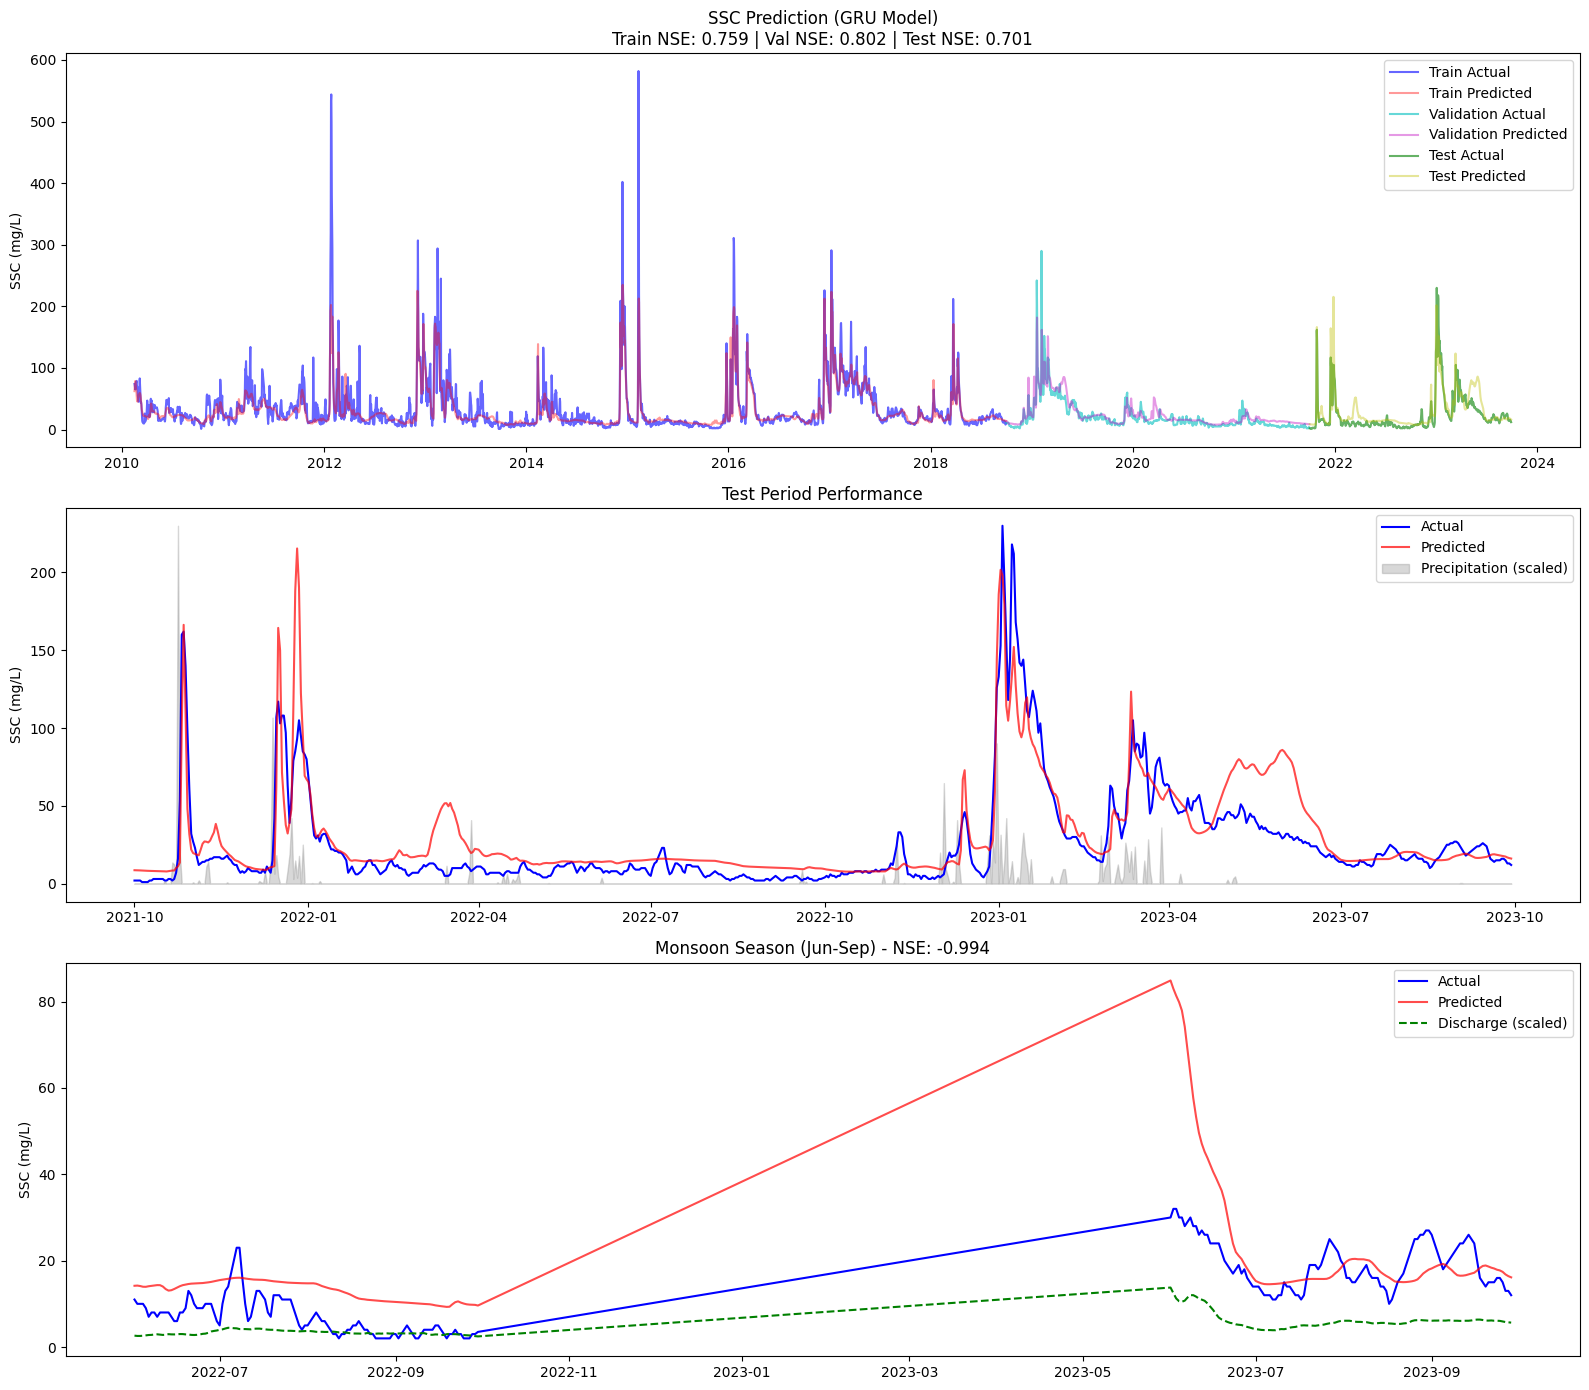

In [16]:
# 10. Visualization

plt.figure(figsize=(16, 14))

# Full timeline plot
plt.subplot(3, 1, 1)
plt.plot(dates[train_mask], y_train_actual, 'b-', alpha=0.6, label='Train Actual')
plt.plot(dates[train_mask], y_train_pred_actual, 'r-', alpha=0.4, label='Train Predicted')
plt.plot(dates[val_mask], y_val_actual, 'c-', alpha=0.6, label='Validation Actual')
plt.plot(dates[val_mask], y_val_pred_actual, 'm-', alpha=0.4, label='Validation Predicted')
plt.plot(dates[test_mask], y_test_actual, 'g-', alpha=0.6, label='Test Actual')
plt.plot(dates[test_mask], y_test_pred_actual, 'y-', alpha=0.4, label='Test Predicted')
plt.title(f'SSC Prediction (GRU Model)\nTrain NSE: {train_nse:.3f} | Val NSE: {val_nse:.3f} | Test NSE: {test_nse:.3f}')
plt.ylabel('SSC (mg/L)')
plt.legend()
plt.grid(False)

# Test period zoom
plt.subplot(3, 1, 2)
test_dates = dates[test_mask]
plt.plot(test_dates, y_test_actual, 'b-', label='Actual')
plt.plot(test_dates, y_test_pred_actual, 'r-', alpha=0.7, label='Predicted')
plt.fill_between(test_dates,
                 df.loc[test_dates, 'Precip_in'] * (y_test_actual.max()/df['Precip_in'].max()),
                 alpha=0.3, color='gray', label='Precipitation (scaled)')
plt.title('Test Period Performance')
plt.ylabel('SSC (mg/L)')
plt.legend()
plt.grid(False)

# Monsoon season focus
if len(y_test_actual) > 0:
    # Extract monsoon period from test set
    monsoon_mask = (test_dates.month >= 6) & (test_dates.month <= 9)
    y_monsoon_actual = y_test_actual[monsoon_mask]
    y_monsoon_pred = y_test_pred_actual[monsoon_mask]
    monsoon_dates = test_dates[monsoon_mask]
    monsoon_nse = nash_sutcliffe(y_monsoon_actual, y_monsoon_pred)

    plt.subplot(3, 1, 3)
    plt.plot(monsoon_dates, y_monsoon_actual, 'b-', label='Actual')
    plt.plot(monsoon_dates, y_monsoon_pred, 'r-', alpha=0.7, label='Predicted')
    plt.plot(monsoon_dates,
             df.loc[monsoon_dates, 'Discharge_cfs'] / df['Discharge_cfs'].max() * y_monsoon_actual.max(),
             'g--', label='Discharge (scaled)')
    plt.title(f'Monsoon Season (Jun-Sep) - NSE: {monsoon_nse:.3f}')
    plt.ylabel('SSC (mg/L)')
    plt.legend()
    plt.grid(False)

plt.tight_layout()
#plt.savefig('ssc_prediction_performance.png', dpi=300)
plt.show()


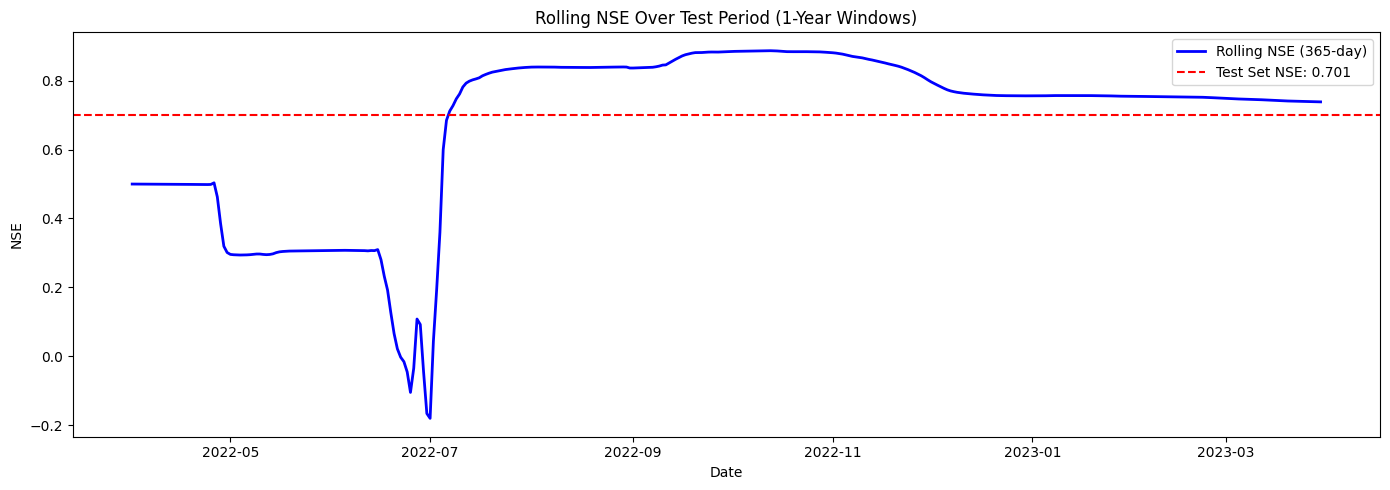

In [17]:
# 12. Rolling NSE Analysis (1-Year Windows)
# ----------------------------
from scipy import stats

def rolling_nse(actual, predicted, dates, window_days=365):
    """
    Compute rolling NSE over a time series with specified window size.
    Returns: dates_center, rolling_nse
    """
    rolling_nse_vals = []
    center_dates = []

    for i in range(window_days, len(actual)):
        start_idx = i - window_days
        actual_window = actual[start_idx:i]
        pred_window = predicted[start_idx:i]

        nse = 1 - (np.sum((actual_window - pred_window)**2) /
                   np.sum((actual_window - np.mean(actual_window))**2))
        rolling_nse_vals.append(nse)
        center_dates.append(dates[start_idx + window_days // 2])  # approximate center

    return np.array(center_dates), np.array(rolling_nse_vals)

# Apply only on test set
if len(y_test_actual) > 0:
    center_dates, roll_nse = rolling_nse(y_test_actual, y_test_pred_actual, test_dates)

    plt.figure(figsize=(14, 5))
    plt.plot(center_dates, roll_nse, 'b-', linewidth=2, label='Rolling NSE (365-day)')
    plt.axhline(test_nse, color='r', linestyle='--', label=f'Test Set NSE: {test_nse:.3f}')
    plt.title('Rolling NSE Over Test Period (1-Year Windows)')
    plt.ylabel('NSE')
    plt.xlabel('Date')
    plt.legend()
    #plt.grid(False, alpha=0.4)
    plt.tight_layout()
    #plt.savefig('rolling_nse_test_period.png', dpi=300)
    plt.show()

Computing permutation importance for 3D sequences (this may take a few minutes)...


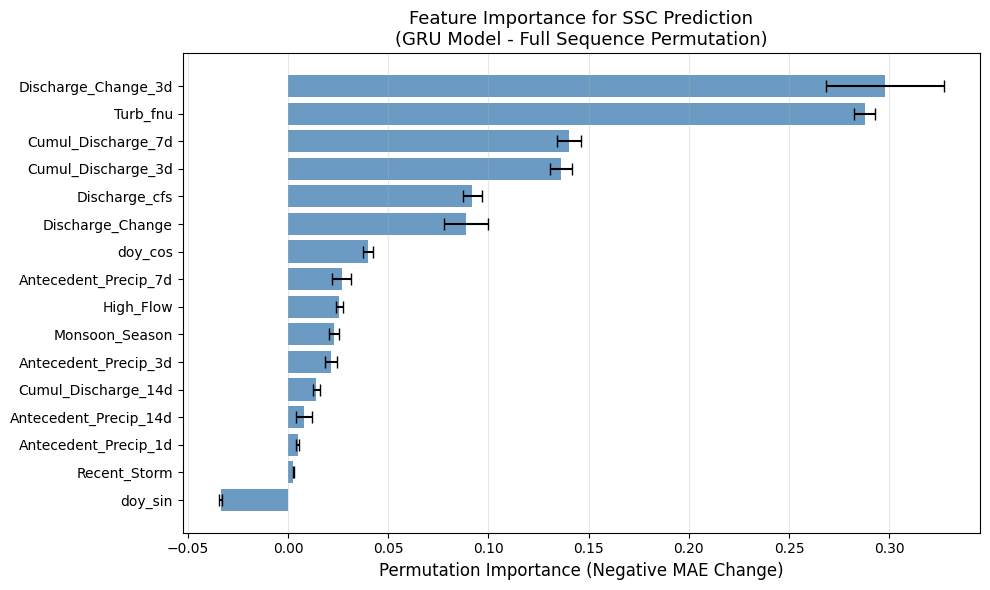


Feature Importance Ranking:
                  Feature  Importance_Mean  Importance_Std
0     Discharge_Change_3d           0.2980          0.0293
1                Turb_fnu           0.2877          0.0051
2      Cumul_Discharge_7d           0.1402          0.0059
3      Cumul_Discharge_3d           0.1364          0.0055
4           Discharge_cfs           0.0920          0.0045
5        Discharge_Change           0.0889          0.0110
6                 doy_cos           0.0399          0.0027
7    Antecedent_Precip_7d           0.0268          0.0047
8               High_Flow           0.0256          0.0016
9          Monsoon_Season           0.0231          0.0025
10   Antecedent_Precip_3d           0.0215          0.0030
11    Cumul_Discharge_14d           0.0141          0.0018
12  Antecedent_Precip_14d           0.0081          0.0041
13   Antecedent_Precip_1d           0.0048          0.0008
14           Recent_Storm           0.0027          0.0003
15                doy_sin  

In [18]:
# 13. CORRECTED Feature Importance for 3D Sequential Data
# ----------------------------
from sklearn.inspection import permutation_importance
import numpy as np

def sequential_permutation_importance_3d(model, X_3d, y_true, scorer, n_repeats=5, random_state=42):
    """
    Compute permutation importance for 3D time series data (samples, timesteps, features)
    by permuting each feature across samples (within each time step).
    """
    np.random.seed(random_state)
    baseline_score = scorer(model, X_3d, y_true)
    importances = np.zeros((len(features), n_repeats))

    for i, feature_idx in enumerate(range(X_3d.shape[2])):
        for repeat in range(n_repeats):
            # Copy the full 3D array
            X_perm = X_3d.copy()
            # Permute the selected feature across all timesteps and samples
            X_perm[:, :, feature_idx] = np.random.permutation(X_perm[:, :, feature_idx].flatten()).reshape(
                X_3d.shape[0], X_3d.shape[1]
            )
            # Score with permuted feature
            try:
                score = scorer(model, X_perm, y_true)
            except:
                score = baseline_score  # fallback
            importances[i, repeat] = baseline_score - score  # importance = drop in performance

    return {
        'importances_mean': np.mean(importances, axis=1),
        'importances_std': np.std(importances, axis=1),
        'importances': importances,
        'baseline_score': baseline_score
    }

# Define a scorer function compatible with 3D input
def neg_mae_scorer(model, X_3d, y_true):
    y_pred = model.predict(X_3d, verbose=0).flatten()
    y_true_flat = y_true.flatten()
    return -np.mean(np.abs(y_true_flat - y_pred))

# Run only if test data exists
if len(X_test) > 0:
    print("Computing permutation importance for 3D sequences (this may take a few minutes)...")
    perm_result = sequential_permutation_importance_3d(
        model, X_test, y_test, neg_mae_scorer, n_repeats=5, random_state=42
    )

    # Sort by importance
    sorted_idx = perm_result['importances_mean'].argsort()[::-1]
    features_array = np.array(features)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(
        features_array[sorted_idx],
        perm_result['importances_mean'][sorted_idx],
        xerr=perm_result['importances_std'][sorted_idx],
        capsize=4,
        color='steelblue',
        alpha=0.8
    )
    plt.xlabel('Permutation Importance (Negative MAE Change)', fontsize=12)
    plt.title('Feature Importance for SSC Prediction\n(GRU Model - Full Sequence Permutation)', fontsize=13)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('feature_importance_clean_3d.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Show ranking
    importance_df = pd.DataFrame({
        'Feature': features_array[sorted_idx],
        'Importance_Mean': perm_result['importances_mean'][sorted_idx],
        'Importance_Std': perm_result['importances_std'][sorted_idx]
    }).round(4)
    print("\nFeature Importance Ranking:")
    print(importance_df)
else:
    print("Skipping feature importance: X_test is empty.")


Best Validation Loss (Huber) during training: 0.0825
Final Validation Loss (Huber): 0.0821
Train WAPE: 26.91%
Validation WAPE: 33.20%
Test WAPE: 43.73%


Text(0.5, 1.0, 'SSC Prediction (GRU Model)\nTrain NSE: 0.759 | Val NSE: 0.802 | Test NSE: 0.701\nVal WAPE: 33.2% | Test WAPE: 43.7%')

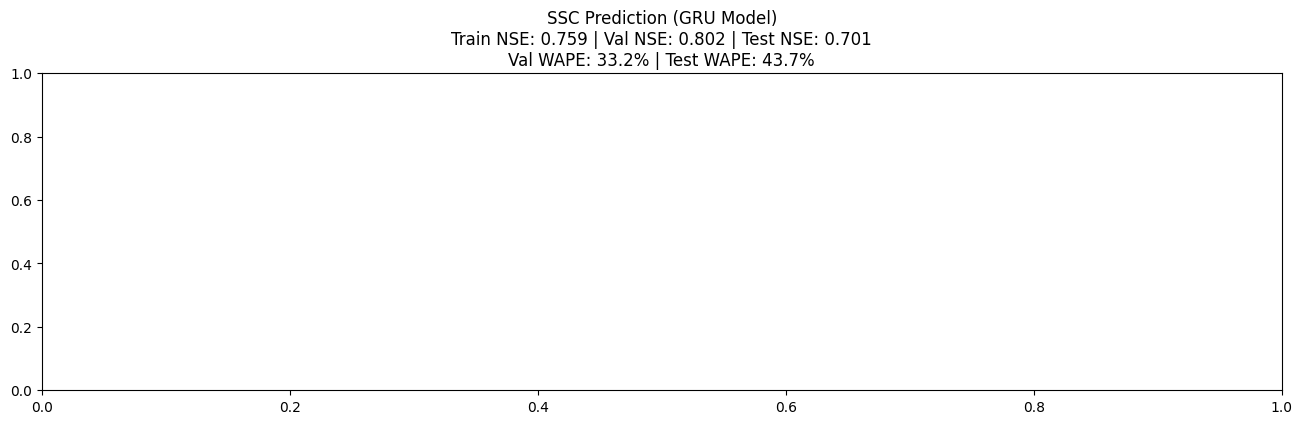

In [20]:
# ----------------------------
# 9.1 Additional Metrics Calculation
# ----------------------------
# 1. Get best validation loss from training history
best_val_loss = min(history.history['val_loss'])
print(f"\nBest Validation Loss (Huber) during training: {best_val_loss:.4f}")

# 2. Calculate current validation loss
val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
print(f"Final Validation Loss (Huber): {val_loss:.4f}")

# 3. Calculate WAPE function
def wape(actual, pred):
    return np.sum(np.abs(actual - pred)) / np.sum(np.abs(actual)) * 100

# 4. Calculate WAPE for all datasets
train_wape = wape(y_train_actual, y_train_pred_actual)
val_wape = wape(y_val_actual, y_val_pred_actual)
test_wape = wape(y_test_actual, y_test_pred_actual)

print(f"Train WAPE: {train_wape:.2f}%")
print(f"Validation WAPE: {val_wape:.2f}%")
print(f"Test WAPE: {test_wape:.2f}%")

# Update plot title with WAPE
plt.figure(figsize=(16, 14))
plt.subplot(3, 1, 1)
# ... [existing plot code] ...
plt.title(f'SSC Prediction (GRU Model)\n'
          f'Train NSE: {train_nse:.3f} | Val NSE: {val_nse:.3f} | Test NSE: {test_nse:.3f}\n'
          f'Val WAPE: {val_wape:.1f}% | Test WAPE: {test_wape:.1f}%')